In [1]:
from Utils import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import os.path
import seaborn as sns



In [14]:
coupling_type = '1JHN'
n_atoms = 23 #Config.MODEL_PARAMS[coupling_type]
train_csv = load_train()
XY_Data = build_XY(train_csv, coupling_type, n_atoms, False)
#XY_Data = pd.read_csv(f'{Config.INPUT_XY}/{coupling_type}.csv', index_col=0)

C:\ProgramFiles\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [15]:
XY_train, XY_Val =  train_test_split(XY_Data, test_size=0.3, random_state=228)
X_val, y_val = build_x_y_data(XY_Val)    

In [16]:
X_train, y_train = build_x_y_data(XY_train)

In [17]:
MY_LGB_PARAMS = {
    'objective': 'regression',
    'metric': 'mae',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 15,
    'min_child_samples': 30,
    'max_depth': 11,
    'reg_alpha': 0.01,
    'reg_lambda': 0.3,
    'bagging_freq': 2000,
    'bagging_fraction': 0.7,
    'bagging_seed': 11,
    'colsample_bytree': 1.0
}

In [18]:
%time 
categorical_features = [col for col in X_train if col.startswith('atom_')]

#X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.3, random_state=228)
# to record eval results for plotting
model = LGBMRegressor(**MY_LGB_PARAMS, n_estimators=3000, n_jobs = -1)
model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
        verbose=100, early_stopping_rounds=1000,
         categorical_feature = categorical_features)

y_pred = model.predict(X_val)
print(mean_absolute_error(y_val, y_pred))
np.log(mean_absolute_error(y_val, y_pred))


Wall time: 0 ns


C:\ProgramFiles\Anaconda\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['atom_10', 'atom_11', 'atom_12', 'atom_13', 'atom_14', 'atom_15', 'atom_16', 'atom_17', 'atom_18', 'atom_19', 'atom_2', 'atom_20', 'atom_21', 'atom_22', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8', 'atom_9']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Training until validation scores don't improve for 1000 rounds.
[100]	training's l1: 0.737115	valid_1's l1: 0.763766
[200]	training's l1: 0.587459	valid_1's l1: 0.639266
[300]	training's l1: 0.510104	valid_1's l1: 0.580409
[400]	training's l1: 0.462249	valid_1's l1: 0.549062
[500]	training's l1: 0.42751	valid_1's l1: 0.528901
[600]	training's l1: 0.399301	valid_1's l1: 0.513667
[700]	training's l1: 0.375107	valid_1's l1: 0.500593
[800]	training's l1: 0.354479	valid_1's l1: 0.489921
[900]	training's l1: 0.33693	valid_1's l1: 0.482455
[1000]	training's l1: 0.322347	valid_1's l1: 0.476335
[1100]	training's l1: 0.308777	valid_1's l1: 0.470298
[1200]	training's l1: 0.29699	valid_1's l1: 0.465319
[1300]	training's l1: 0.286688	valid_1's l1: 0.462209
[1400]	training's l1: 0.277021	valid_1's l1: 0.458693
[1500]	training's l1: 0.268214	valid_1's l1: 0.455695
[1600]	training's l1: 0.260226	valid_1's l1: 0.452525
[1700]	training's l1: 0.252783	valid_1's l1: 0.449942
[1800]	training's l1: 0.245817

-0.8608798926771997

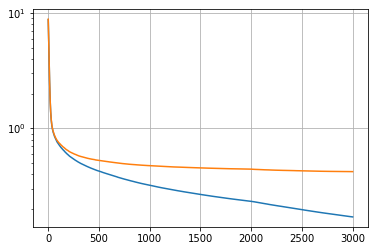

In [19]:
eval_results = model.evals_result_
l1 = eval_results["training"]["l1"]
plt.plot(l1)

valid = eval_results["valid_1"]["l1"]
plt.plot(valid)

#ax.set_yticks(np.linspace(100, 1000, 10))
plt.yscale('log')
plt.grid(True)

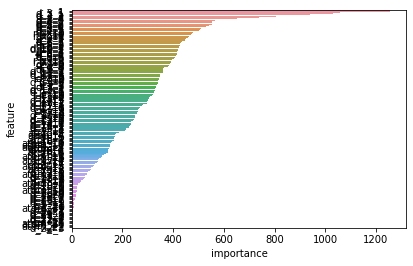

In [20]:
cols = list(X_train.columns)
#cols.remove('scalar_coupling_constant')
cols
df_importance = pd.DataFrame({'feature': cols, 'importance': model.feature_importances_})
sns.barplot(x="importance", y="feature", data=df_importance.sort_values('importance', ascending=False));

In [23]:
df_importance.sort_values('importance', ascending=False)

,feature,importance
21,r_x_1,1257
87,d_3_1,1060
85,d_2_1,1029
88,d_3_2,939
22,r_x_2,804
23,r_x_3,740
86,d_3_0,654
92,d_4_3,567
91,d_4_2,553
95,d_5_2,553


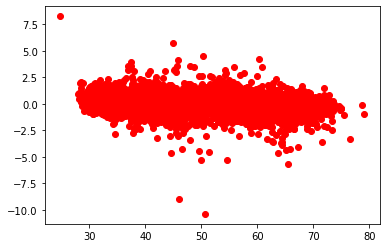

In [22]:
plt.plot(y_val, y_pred- y_val, 'ro')

In [13]:
(y_pred- y_val).describe()

count    13009.000000
mean        -0.002560
std          0.620722
min         -9.594583
25%         -0.274899
50%          0.011772
75%          0.285150
max          6.422374
Name: scalar_coupling_constant, dtype: float64